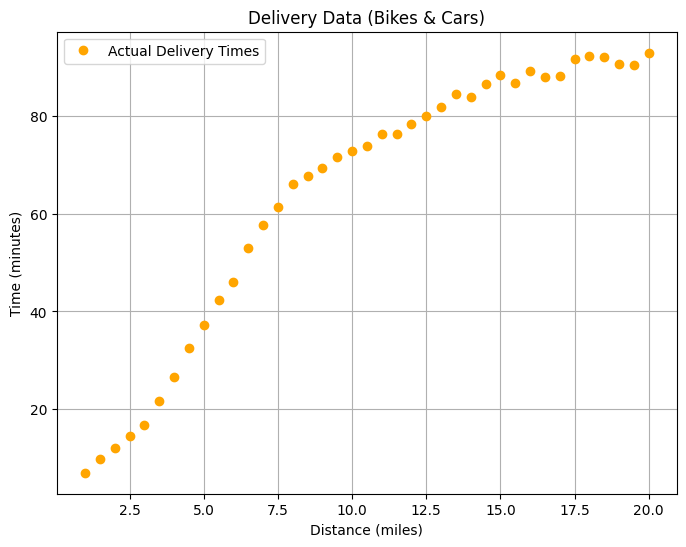

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import utils

#Prepari ng the non-learn data
# Combined dataset: bikes for short distances, cars for longer ones
distances = torch.tensor([
    [1.0], [1.5], [2.0], [2.5], [3.0], [3.5], [4.0], [4.5], [5.0], [5.5],
    [6.0], [6.5], [7.0], [7.5], [8.0], [8.5], [9.0], [9.5], [10.0], [10.5],
    [11.0], [11.5], [12.0], [12.5], [13.0], [13.5], [14.0], [14.5], [15.0], [15.5],
    [16.0], [16.5], [17.0], [17.5], [18.0], [18.5], [19.0], [19.5], [20.0]
], dtype=torch.float32)

# Corresponding delivery times in minutes
times = torch.tensor([
    [6.96], [9.67], [12.11], [14.56], [16.77], [21.7], [26.52], [32.47], [37.15], [42.35],
    [46.1], [52.98], [57.76], [61.29], [66.15], [67.63], [69.45], [71.57], [72.8], [73.88],
    [76.34], [76.38], [78.34], [80.07], [81.86], [84.45], [83.98], [86.55], [88.33], [86.83],
    [89.24], [88.11], [88.16], [91.77], [92.27], [92.13], [90.73], [90.39], [92.98]
], dtype=torch.float32)

utils.plot_data(distances, times)

### A New Step: Normalizing the Data

Before building your model, you will apply a quick data preparation step called **normalization**. This is a standard technique that makes the training process more stable and effective by adjusting the scale of the data. This adjustment helps prevent large distance values from dominating the learning process and keeps gradients stable during training. 

* You will calculate the mean and standard deviation for the `distances` and `times` tensors.
* You will then apply standardization to each tensor using its respective mean and standard deviation, which creates new normalized tensors named `distances_norm` and `times_norm`.
* This specific technique is called **standardization** (or z-score normalization), which converts the original data from `1.0 to 20.0 miles` and approximately `7 to 93 minutes` into a new, normalized scale.

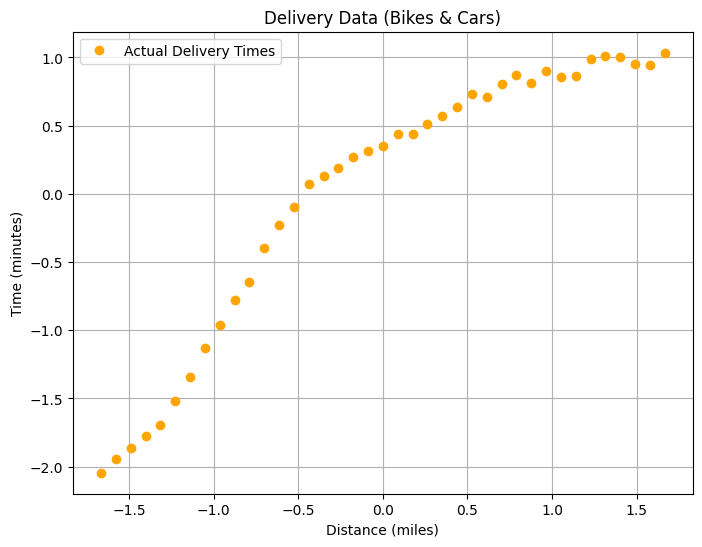

In [2]:
#Calculate the mean and standard deviation for the distance tensor
distances_mean = distances.mean()
distances_std = distances.std()

#Calculate the means and standard deviation for the time tensor
times_mean = times.mean()
times_std = times.std()

#Apply standardization to the distances
distances_norm = (distances-distances_mean)/distances_std

#Apply standardization to the time
times_norm = (times-times_mean)/times_std

utils.plot_data(distances_norm, times_norm)

## Building the Non-Linear Model

With your normalized data ready, you can now build a model capable of learning its curved pattern. You will define the model's architecture, which now includes a `ReLU` activation function. This structure is what gives your model the ability to learn non-linear relationships.

* `nn.Linear(1, 3)`: This is your **first hidden layer**. It consists of three neurons, each receiving one input feature (the normalized distance). This layer transforms the single input value into three separate values.
* `nn.ReLU()` applies the ReLU activation function to the output of each of the three neurons from the hidden layer. This is the crucial non-linear step that allows your model to create "bends" and learn curves instead of just straight lines.
* `nn.Linear(3, 1)`: This is your **output layer**. It takes the three activated values from the previous step as its input and combines them to produce a single final output, which is your predicted (normalized) delivery time.

This creates a neural network with 1 hidden layer containing 3 neurons.

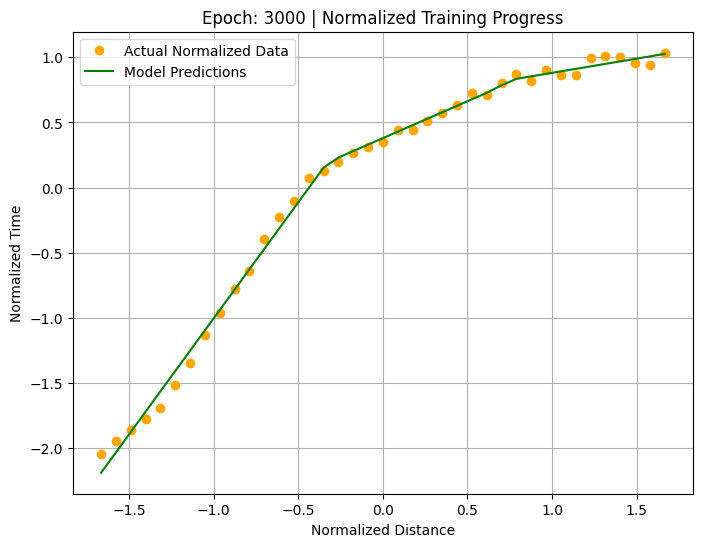


Training Complete.

Final Loss: 0.0031437124125659466


In [5]:
#Below line insure that results are reproducible and consistent every time
torch.manual_seed(27)

model = nn.Sequential(
    nn.Linear(1, 3),
    nn.ReLU(),
    nn.Linear(3, 1)
)

#Define the loss function and optimizer
loss_function = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

#You will run the training loop for 3000 epochs (more than Lab 1 because the non-linear pattern is more complex and requires more training). 
# This will repeatedly feed the normalized data to your model, measure the error, and adjust the model's parameters to improve its predictions.
# The second half of the code includes a live plot, allowing you to watch in real time as your model's prediction line adapts to fit the curved data. 
# The live plot helps you see how your model gradually learns to fit the curve, starting with a poor fit and improving over time.

for epoch in range(3000):
    #Reset the optimizer's gradient
    optimizer.zero_grad()
    #Make predictions (forward pass)
    output = model(distances_norm)

    #Calculate loss function 
    loss = loss_function(output, times_norm)

    #Calcular adjustment (backward pass)
    loss.backward()
    #update the model parameters
    optimizer.step()

    #Create a live plot every 50 epochs
    if(epoch+1) % 50 == 0:
        utils.plot_training_progress(
            epoch=epoch,
            loss=loss,
            model=model,
            distances_norm=distances_norm,
            times_norm=times_norm
        )

print("\nTraining Complete.")
print(f"\nFinal Loss: {loss.item()}")

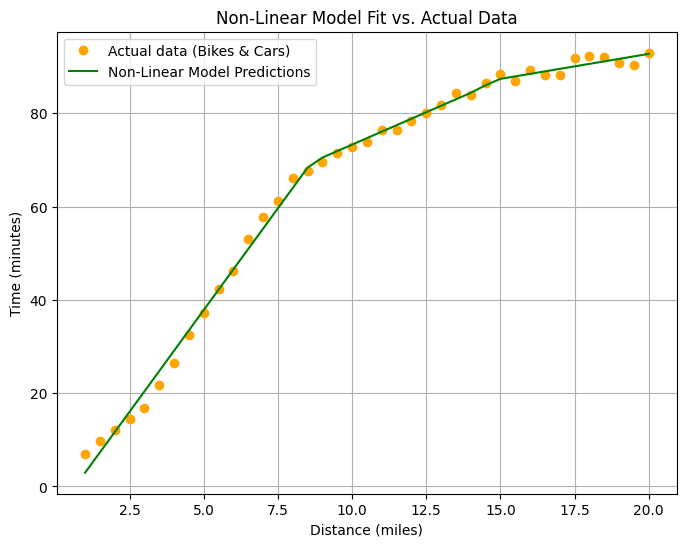

In [6]:
#Check the final fit

utils.plot_final_fit(model, distances, times, distances_norm, times_std, times_mean)

## Making a Prediction

With your fully trained non-linear model, you can now use it to make a prediction for a new delivery. The process is slightly different now because your model was trained on *normalized* data.

* First, you will take the new input distance and **normalize** it using the same mean and standard deviation from your training data. This step is CRITICAL: your model has no idea about the original scales (miles and minutes). It only understands the normalized scale it was trained on.
* After the model provides its prediction, you must **de-normalize** the output. This converts the prediction from its normalized scale back into an understandable value in minutes.
* Finally, the code uses this actual predicted time to run the decision logic. For this prediction, assume your company now promises deliveries within 45 minutes (instead of 30 minutes from Lab 1) and wants to know which vehicle to use.

In [7]:
distance_to_predict = 5.1

with torch.no_grad():
    #Normalize the input distance 
    distance_tensor = torch.tensor([[distance_to_predict]], dtype=torch.float32)
    new_distance_norm= (distance_tensor-distances_mean) / distances_std

    #Get the normalize prediction form the model 
    prediction_time_norm = model(new_distance_norm)

    #De-normalize the output to get the actual time in minutes
    predicted_time_actual = (prediction_time_norm * times_std) + times_mean

    #Decision making logic
    print(f"Prediction for a {distance_to_predict}- mile delivery: {predicted_time_actual.item():.1f} minutes")

    # First, check if the delivery is possible within the 45-minute timeframe
    if predicted_time_actual.item() > 45:
        print("\nDecision: Do NOT promise the delivery in under 45 minutes.")
    else:
        # If it is possible, then determine the vehicle based on the distance
        if distance_to_predict <= 3:
            print(f"\nDecision: Yes, delivery is possible. Since the distance is {distance_to_predict} miles (<= 3 miles), use a bike.")
        else:
            print(f"\nDecision: Yes, delivery is possible. Since the distance is {distance_to_predict} miles (> 3 miles), use a car.")

Prediction for a 5.1- mile delivery: 38.7 minutes

Decision: Yes, delivery is possible. Since the distance is 5.1 miles (> 3 miles), use a car.
